In [4]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from time import time

In [3]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_max_depth1 = 3
best_lr1 = 0.3
best_gamma1 = 0.2
best_reg_lambda1 = 0.4
best_scale_pos_weight1 = 1

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_max_depth2 = 9
best_lr2 = 0.1
best_gamma2 = 0.3
best_reg_lambda2 = 0.3
best_scale_pos_weight2 = 1

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(columns=['round_winner'])
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_max_depth3 = 9
best_lr3 = 0.05
best_gamma3 = 0.3
best_reg_lambda3 = 0
best_scale_pos_weight3 = 1

datasets = [(X1, y1, ds1_name, best_max_depth1, best_lr1, best_gamma1, best_reg_lambda1, best_scale_pos_weight1),
            (X2, y2, ds2_name, best_max_depth2, best_lr2, best_gamma2, best_reg_lambda2, best_scale_pos_weight2),
            (X3, y3, ds3_name, best_max_depth3, best_lr3, best_gamma3, best_reg_lambda3, best_scale_pos_weight3)]

Dataset: match_data - Best max_depth: 3, Best learning rate: 0.3, Best gamma: 0.2, Best reg_lambda: 0.4, Best scale_pos_weight: 1
Time to fit and predict: 1.9171028137207031 seconds
              precision    recall  f1-score   support

           0       0.61      0.58      0.59       252
           1       0.61      0.64      0.63       259

    accuracy                           0.61       511
   macro avg       0.61      0.61      0.61       511
weighted avg       0.61      0.61      0.61       511

                 Predicted Negative  Predicted Positive
Actual Negative                 145                 107
Actual Positive                  92                 167
ROC AUC: 0.675821229392658
Dataset: rounds_data - Best max_depth: 9, Best learning rate: 0.1, Best gamma: 0.3, Best reg_lambda: 0.3, Best scale_pos_weight: 1
Time to fit and predict: 10.821300983428955 seconds
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1148
    

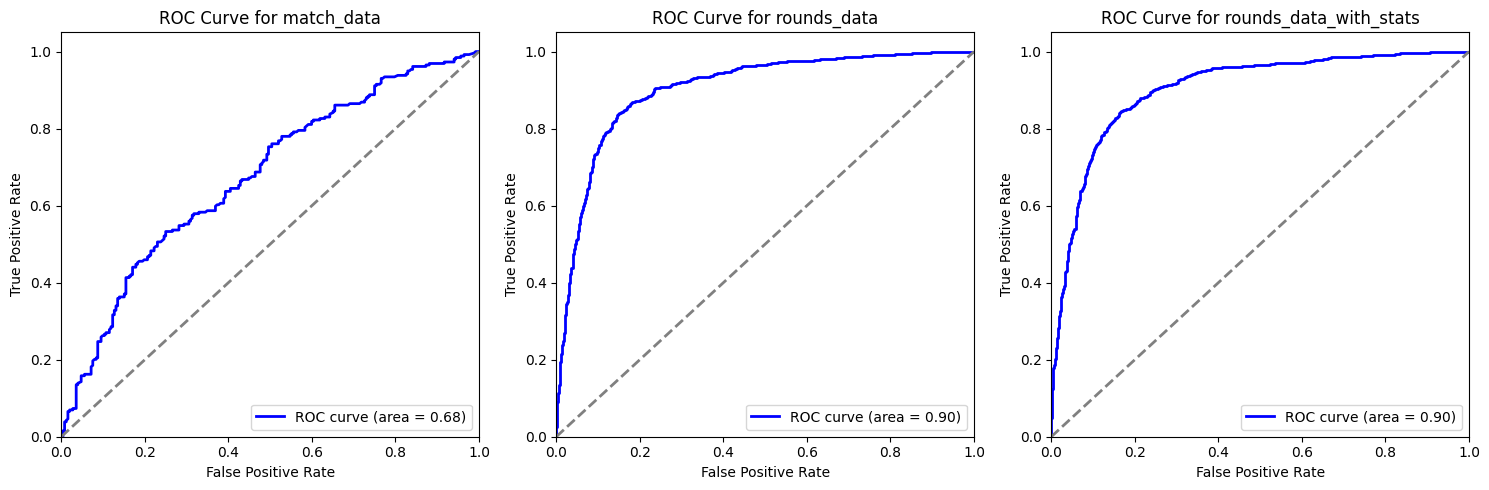

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, (X, y, ds_name, best_max_depth, best_lr, best_gamma, best_reg_lambda, best_scale_pos_weight) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10000, max_depth=best_max_depth, learning_rate=best_lr, gamma=best_gamma, reg_lambda=best_reg_lambda,
                        scale_pos_weight=best_scale_pos_weight, verbosity=0)
    
    start_time = time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    print(f"Dataset: {ds_name} - Best max_depth: {best_max_depth}, Best learning rate: {best_lr}, Best gamma: {best_gamma}, Best reg_lambda: {best_reg_lambda}, Best scale_pos_weight: {best_scale_pos_weight}")
    print(f"Time to fit and predict: {time() - start_time} seconds")

    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs)}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    axs[idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs):.2f})')
    axs[idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[idx].set_xlim([0.0, 1.0])
    axs[idx].set_ylim([0.0, 1.05])
    axs[idx].set_xlabel('False Positive Rate')
    axs[idx].set_ylabel('True Positive Rate')
    axs[idx].set_title(f'ROC Curve for {ds_name}')
    axs[idx].legend(loc='lower right')

plt.tight_layout()
plt.show()